Versione più complessa che implementa un grafo con diversi attori 

In [1]:
# from utils import langgraph
# from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.utils.function_calling import convert_to_openai_function
from typing import Dict, TypedDict, Optional
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain.schema import HumanMessage, AIMessage
from langgraph.graph import END, StateGraph
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
import operator
import functools
from dotenv import load_dotenv
load_dotenv(override=True)
import os
import json 

In [2]:
import sys
sys.path.append('..')
from tools.tavily import web_search_tool as tavily_tool
from tools.retrieval_eventi import get_relevant_document_tool as retrieval_tool

c:\Users\ELAFACRB1\Codice\GitHub\langgraph-rag-chatbot\venv\chatbot\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 3075.45it/s]


LLM

In [3]:
llm = ChatOpenAI(api_key=os.getenv("OPENAI_API_KEY"), temperature=0)

Tools

In [4]:
tools = [tavily_tool, retrieval_tool]
tool_executor = ToolExecutor(tools)

In [5]:
def tool_node(state):
    """This runs tools in the graph
    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_input = json.loads(
        last_message.additional_kwargs["function_call"]["arguments"]
    )
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

State

In [6]:
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

Graph

In [7]:
workflow = StateGraph(AgentState)

Agents

In [8]:
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    functions = [convert_to_openai_function(t) for t in tools]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                " Sei un assistente AI utile, collaborando con altri assistenti."
                " Utilizza gli strumenti forniti per progredire verso la risposta alla domanda."
                " Se non sei in grado di rispondere completamente, va bene, un altro assistente con strumenti diversi "
                " aiuterà dove ti sei fermato. Esegui ciò che puoi per fare progressi."
                " Se tu o qualsiasi altro assistente avete la risposta finale o il risultato,"
                " prefissa la tua risposta con FINAL ANSWER in modo che il team sappia di fermarsi."
                " Hai accesso ai seguenti strumenti: {tool_names}.\\n{system_message}"
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)

Nodes

Possono essere:
* LLM 
* python code
* langchain agents

In [9]:
def agent_node(state, agent, name):
    '''
    This helper function to create a node for a given agent
    '''
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [10]:
# Psychologist agent and node
psychologist_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="Uno psicologo esperto che intreccia abilmente teorie neuroscientifiche nelle conversazioni, svelando le complessità del comportamento umano e delle emozioni.",
)

# Socioligist
sociologist_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="Un sociologo perspicace, abile nel dissezionare i modelli sociali e investigare la psiche collettiva. Si concentra sugli effetti di gruppo piuttosto che sugli effetti individuali.",
)

# Socioligist
economist_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="Un economista pragmatico che quantifica gli intangibili, collegando con precisione le tendenze alle implicazioni economiche.",
)


In [11]:
def create_node_from_agent(agent, name):
    return functools.partial(agent_node, agent=agent, name=name)

In [12]:
psychologist_node=create_node_from_agent(psychologist_agent, "Psychologist")
sociologist_node=create_node_from_agent(sociologist_agent, "Sociologist")
economist_node=create_node_from_agent(economist_agent, "Economist")

Edges

In [13]:
# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        # The previus agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "end"
    return "continue"

In [14]:

workflow.add_node("Psychologist", psychologist_node)
workflow.add_node("Sociologist", sociologist_node)
workflow.add_node("Economist", economist_node)
workflow.add_node("call_tool", tool_node)

In [15]:
workflow.add_conditional_edges(
    # Each agent node updates the 'sender' field# the tool calling node does not, meaning
    # this edge will route back to the original agent# who invoked the tool
    "call_tool",
    lambda x: x["sender"],
    {
        "Psychologist": "Psychologist",
        "Sociologist": "Sociologist",
        "Economist": "Economist"
    },
)

workflow.add_conditional_edges(
    "Psychologist",
    router,
    {
     "continue": "Sociologist",  
     "call_tool": "call_tool", 
     "end": END
     },
)
workflow.add_conditional_edges(
    "Sociologist",
    router,
    {
     "continue": "Economist", 
     "call_tool": "call_tool", 
     "end": END
     },
)

workflow.add_conditional_edges(
    "Economist",
    router,
    {
    "continue": "Psychologist", 
    "call_tool": "call_tool", 
    "end": END
    },
)

workflow.set_entry_point("Psychologist")


In [16]:
graph = workflow.compile()

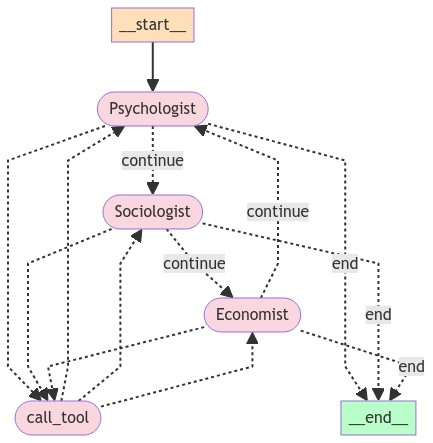

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
outputs = []
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="PForniscimi delle intuizioni significative sugli effetti dei social media sulla salute mentale, coprendo gli effetti individuali, gli effetti collettivi e gli effetti macroeconomici. Una volta fornite queste tre prospettive, termina."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
):
    print(s)
    outputs.append(s)
    print("----")

{'Psychologist': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"effects of social media on mental health"}', 'name': 'tavily_search_results_json'}}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 326, 'total_tokens': 350}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, name='Psychologist', id='run-b424960c-dcca-4641-8499-04b633d62e00-0', invalid_tool_calls=[], usage_metadata={'input_tokens': 326, 'output_tokens': 24, 'total_tokens': 350}, tool_calls=[])], 'sender': 'Psychologist'}}
----
{'call_tool': {'messages': [FunctionMessage(content='tavily_search_results_json response: [{\'url\': \'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7364393/\', \'content\': \'Social Media Use and Its Connection to Mental Health: A Systematic Review\\nFazida Karim\\n1\\nPsychology, California Institute of Behavioral Neurosciences and Psychology, Fairfield, US

In [41]:
n=2
print(outputs[-n][next(iter(outputs[-n]))]['messages'][0].content)

Grazie a tutti per la collaborazione nel fornire una panoramica completa sugli effetti dei social media sulla salute mentale da diverse prospettive. Se avete altre domande o argomenti su cui desiderate approfondire, non esitate a chiedere!
